In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Import and clean data

In [2]:
def text_cleaner(text):
    text = re.sub(r'--', ' ', text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)

alice = text_cleaner(alice[:int(len(alice)/10)])
persuasion = text_cleaner(persuasion[:int(len(persuasion)/10)])

nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
per_sents = [[sent, 'Austen'] for sent in persuasion_doc.sents]
sentences = pd.DataFrame(alice_sents + per_sents)

In [3]:
def bag_of_words(text):
    allwords = [token.lemma_
               for token in text
               if not token.is_punct
               and not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(2000)]

def bow_features(sentences, common_words):
    df = pd.DataFrame(columns = common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_
                for token in sentence
                if (
                    not token.is_punct
                    and not token.is_stop
                    and token.lemma_ in common_words
                )]
        
        for word in words:
            df.loc[i, word] +=1
            
        if i % 50 == 0:
            print('Processing row {}'.format(i))
            
    return df

alicewords = bag_of_words(alice_doc)
perwords = bag_of_words(persuasion_doc)

common_words = set(alicewords+perwords)

In [4]:
word_counts = bow_features(sentences, common_words)

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400


In [5]:
y = word_counts['text_source']
x = np.array(word_counts.drop(['text_sentence', 'text_source'], 1))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

In [6]:
lr = LogisticRegression(penalty='l2', random_state=99)
train_lr = lr.fit(x_train, y_train)
print(x_train.shape, y_train.shape)
print('Training set score:', lr.score(x_train, y_train))
print('\nTest set score:', lr.score(x_test, y_test))

(266, 1612) (266,)
Training set score: 0.9699248120300752

Test set score: 0.8764044943820225


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Improving performance
### Look at text to get ideas for features

In [7]:
alice[:1000]

"Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her. There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually TOOK A WATCH OUT OF ITS WAISTCOAT-POCKET, and looked at it, and th

In [8]:
alice[9003:10003]

"uld be like then?' And she tried to fancy what the flame of a candle is like after the candle is blown out, for she could not remember ever having seen such a thing. After a while, finding that nothing more happened, she decided on going into the garden at once; but, alas for poor Alice! when she got to the door, she found she had forgotten the little golden key, and when she went back to the table for it, she found she could not possibly reach it: she could see it quite plainly through the glass, and she tried her best to climb up one of the legs of the table, but it was too slippery; and when she had tired herself out with trying, the poor little thing sat down and cried. 'Come, there's no use in crying like that!' said Alice to herself, rather sharply; 'I advise you to leave off this minute!' She generally gave herself very good advice, (though she very seldom followed it), and sometimes she scolded herself so severely as to bring tears into her eyes; and once she remembered trying

In [9]:
persuasion[:1000]

'Sir Walter Elliot, of Kellynch Hall, in Somersetshire, was a man who, for his own amusement, never took up any book but the Baronetage; there he found occupation for an idle hour, and consolation in a distressed one; there his faculties were roused into admiration and respect, by contemplating the limited remnant of the earliest patents; there any unwelcome sensations, arising from domestic affairs changed naturally into pity and contempt as he turned over the almost endless creations of the last century; and there, if every other leaf were powerless, he could read his own history with an interest which never failed. This was the page at which the favourite volume always opened: "ELLIOT OF KELLYNCH HALL. "Walter Elliot, born March 1, 1760, married, July 15, 1784, Elizabeth, daughter of James Stevenson, Esq. of South Park, in the county of Gloucester, by which lady (who died 1800) he has issue Elizabeth, born June 1, 1785; Anne, born August 9, 1787; a still-born son, November 5, 1789; 

In [10]:
persuasion[9003:11003]

' supported by her father, had disappointed her. She had, while a very young girl, as soon as she had known him to be, in the event of her having no brother, the future baronet, meant to marry him, and her father had always meant that she should. He had not been known to them as a boy; but soon after Lady Elliot\'s death, Sir Walter had sought the acquaintance, and though his overtures had not been met with any warmth, he had persevered in seeking it, making allowance for the modest drawing-back of youth; and, in one of their spring excursions to London, when Elizabeth was in her first bloom, Mr Elliot had been forced into the introduction. He was at that time a very young man, just engaged in the study of the law; and Elizabeth found him extremely agreeable, and every plan in his favour was confirmed. He was invited to Kellynch Hall; he was talked of and expected all the rest of the year; but he never came. The following spring he was seen again in town, found equally agreeable, again

Both books seem to have very long sentences with a lot of commas.

Potential differences:
- Length of sentence (maybe Austin slightly longer?)
- Longer words in Austin
- More exclamation points in Carroll
- More capital letters in Carroll
- More dates / numbers in Austin
- More paretheses in Carroll
- More speech marks in Carroll

### Create more features

In [11]:
## Sentence length including punctuation

word_counts['sen_len_p'] = np.nan
for row in np.arange(0, len(word_counts)):
    word_counts.loc[row, 'sen_len_p'] = len(word_counts.loc[row, 'text_sentence'])

In [12]:
word_counts.head()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,nation,privilege,longer,urge,spurn,fellow,make,text_sentence,text_source,sen_len_p
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll,67.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,"(So, she, was, considering, in, her, own, mind...",Carroll,63.0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll,30.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll,3.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll,3.0


In [13]:
## Punctuation in sentence

word_counts['punctuation'] = np.nan
for row in np.arange(0, len(word_counts)):
    punct = 0
    for token in word_counts.loc[row, 'text_sentence']:
        if token.is_punct:
            punct += 1
    word_counts.loc[row, 'punctuation'] = punct

In [14]:
word_counts.head()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,privilege,longer,urge,spurn,fellow,make,text_sentence,text_source,sen_len_p,punctuation
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll,67.0,10.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,"(So, she, was, considering, in, her, own, mind...",Carroll,63.0,7.0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll,30.0,3.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"(Oh, dear, !)",Carroll,3.0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"(Oh, dear, !)",Carroll,3.0,1.0


In [15]:
## Sentence length without punctuation

word_counts['sen_len'] = word_counts['sen_len_p'] - word_counts['punctuation']

In [16]:
## Punctuation per word

word_counts['ppw'] = word_counts['punctuation'] / word_counts['sen_len']

In [17]:
## Average word length in a sentence

word_counts['av_word_len'] = np.nan

for row in np.arange(0, len(word_counts)):
    total_l = 0
    for token in word_counts.loc[row, 'text_sentence']:
        if (not token.is_punct):
            total_l += len(token)
        av_l = total_l / word_counts.loc[row, 'sen_len']
    word_counts.loc[row, 'av_word_len'] = av_l

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [18]:
word_counts.head()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,spurn,fellow,make,text_sentence,text_source,sen_len_p,punctuation,sen_len,ppw,av_word_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll,67.0,10.0,57.0,0.175439,4.122807
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,"(So, she, was, considering, in, her, own, mind...",Carroll,63.0,7.0,56.0,0.125000,4.071429
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll,30.0,3.0,27.0,0.111111,3.777778
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(Oh, dear, !)",Carroll,3.0,1.0,2.0,0.500000,3.000000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(Oh, dear, !)",Carroll,3.0,1.0,2.0,0.500000,3.000000


In [19]:
## Exclamation points

word_counts['excl_points'] = np.nan

for row in np.arange(0, len(word_counts)):
    total_l = 0
    for token in word_counts.loc[row, 'text_sentence']:
        if (str(token) == str(nlp('!')[0])):
            total_l += 1
    word_counts.loc[row, 'excl_points'] = total_l

In [20]:
## Speech marks (' or ")
## Put these together because not fair to use as separator because
## just chance of formatting.
## Will include apostrophes as well I guess

word_counts['speech_marks'] = np.nan

for row in np.arange(0, len(word_counts)):
    speech = 0
    for token in word_counts.loc[row, 'text_sentence']:
        if(str(token) == str('"')):
            speech += 1
        elif(str(token) == str("'")):
            speech += 1
    word_counts.loc[row, 'speech_marks'] = speech

In [21]:
word_counts.head()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,make,text_sentence,text_source,sen_len_p,punctuation,sen_len,ppw,av_word_len,excl_points,speech_marks
0,0,0,0,0,0,0,0,0,0,0,...,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll,67.0,10.0,57.0,0.175439,4.122807,0.0,4.0
1,0,0,0,0,0,0,0,0,0,0,...,1,"(So, she, was, considering, in, her, own, mind...",Carroll,63.0,7.0,56.0,0.125000,4.071429,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll,30.0,3.0,27.0,0.111111,3.777778,0.0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,"(Oh, dear, !)",Carroll,3.0,1.0,2.0,0.500000,3.000000,1.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,"(Oh, dear, !)",Carroll,3.0,1.0,2.0,0.500000,3.000000,1.0,0.0


In [22]:
## Words in capitals

word_counts['capitals'] = np.nan

for row in np.arange(0, len(word_counts)):
    caps = 0
    for token in word_counts.loc[row, 'text_sentence']:
        if(re.match(r'\b[A-Z]+\b', str(token))):
            caps += 1
    word_counts.loc[row, 'capitals'] = caps
        

In [23]:
word_counts.head()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,text_sentence,text_source,sen_len_p,punctuation,sen_len,ppw,av_word_len,excl_points,speech_marks,capitals
0,0,0,0,0,0,0,0,0,0,0,...,"(Alice, was, beginning, to, get, very, tired, ...",Carroll,67.0,10.0,57.0,0.175439,4.122807,0.0,4.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,"(So, she, was, considering, in, her, own, mind...",Carroll,63.0,7.0,56.0,0.125000,4.071429,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,"(There, was, nothing, so, VERY, remarkable, in...",Carroll,30.0,3.0,27.0,0.111111,3.777778,0.0,1.0,2.0
3,0,0,0,0,0,0,0,0,0,0,...,"(Oh, dear, !)",Carroll,3.0,1.0,2.0,0.500000,3.000000,1.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,"(Oh, dear, !)",Carroll,3.0,1.0,2.0,0.500000,3.000000,1.0,0.0,0.0


In [24]:
## Types of words used
print(nlp('I need to break the glass')[3].pos_)

VERB


In [25]:
## New features table for word types

def bow_features2(word_counts):
    dict_of_dicts = {}
    for row in np.arange(0, len(word_counts)):
        dict_of_dicts[str(row)+'dict'] = {}
        for token in word_counts.loc[row, 'text_sentence']:
            if(str(token.pos_) in dict_of_dicts[str(row)+'dict']):
                dict_of_dicts[str(row)+'dict'][str(token.pos_)] += 1
            else:
                dict_of_dicts[str(row)+'dict'][str(token.pos_)] = 1
    #print(dict_of_dicts)
    long_list = []
    for d in dict_of_dicts:
        long_list.extend(list(dict_of_dicts[d].keys()))
        
    unique_types = set(long_list)
    #print(unique_types)            
    df = pd.DataFrame(columns = unique_types)
    df['text_sentence'] = word_counts['text_sentence']
    df.loc[:, unique_types] = 0
    #print(df)
    for row in np.arange(0, len(word_counts)):
        for t in dict_of_dicts[str(row)+'dict']:
            df.loc[row, t] = dict_of_dicts[str(row)+'dict'][t] / len(word_counts.loc[row, 'text_sentence'])
            #print(dict_of_dicts[str(row)+'dict'][t])
        if row % 50 == 0:
            print('Processing row {}'.format(row))
        #print(df.head(10))    
    return df

In [26]:
type_counts = bow_features2(word_counts)

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400


In [27]:
type_counts

,PRON,PROPN,DET,VERB,CCONJ,NUM,PART,ADP,NOUN,PUNCT,ADV,INTJ,AUX,ADJ,text_sentence
0,0.0597015,0.0298507,0.104478,0.19403,0.0895522,0,0.0298507,0.119403,0.164179,0.149254,0.0447761,0,0,0.0149254,"(Alice, was, beginning, to, get, very, tired, ..."
1,0.0634921,0.031746,0.111111,0.174603,0.031746,0,0.015873,0.126984,0.126984,0.111111,0.111111,0,0,0.0952381,"(So, she, was, considering, in, her, own, mind..."
2,0.0666667,0.0666667,0.1,0.166667,0.0333333,0,0.0333333,0.133333,0.0666667,0.1,0.2,0,0,0.0333333,"(There, was, nothing, so, VERY, remarkable, in..."
3,0,0,0,0,0,0,0,0,0,0.333333,0,0.333333,0,0.333333,"(Oh, dear, !)"
4,0,0,0,0,0,0,0,0,0,0.333333,0,0.333333,0,0.333333,"(Oh, dear, !)"
5,0.166667,0,0,0.333333,0,0,0,0,0,0.333333,0,0,0,0.166667,"(I, shall, be, late, !, ')"
6,0.157895,0.0263158,0.105263,0.184211,0.0526316,0,0.0526316,0.105263,0.0263158,0.131579,0.131579,0,0,0.0263158,"((, when, she, thought, it, over, afterwards, ..."
7,0.0555556,0.111111,0.111111,0.111111,0.111111,0,0.0555556,0.111111,0.0555556,0.166667,0.0555556,0,0,0.0555556,"(A, WATCH, OUT, OF, ITS, WAISTCOAT, -, POCKET,..."
8,0.0857143,0.0142857,0.114286,0.142857,0.0571429,0,0.0428571,0.171429,0.171429,0.128571,0.0571429,0,0,0.0142857,"(,, Alice, started, to, her, feet, ,, for, it,..."
9,0.0869565,0.0434783,0.0869565,0.173913,0,0,0.130435,0.130435,0.0869565,0.0869565,0.173913,0,0,0,"(In, another, moment, down, went, Alice, after..."


In [28]:
type_counts.shape

(444, 15)

In [29]:
word_counts.shape

(444, 1622)

In [30]:
word_and_type = pd.concat([word_counts.drop(['text_source', 'text_sentence'], axis=1), type_counts.drop(['text_sentence'], axis=1), word_counts[['text_source', 'text_sentence']]], axis=1)

In [31]:
word_and_type.head()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,PART,ADP,NOUN,PUNCT,ADV,INTJ,AUX,ADJ,text_source,text_sentence
0,0,0,0,0,0,0,0,0,0,0,...,0.0298507,0.119403,0.164179,0.149254,0.0447761,0,0,0.0149254,Carroll,"(Alice, was, beginning, to, get, very, tired, ..."
1,0,0,0,0,0,0,0,0,0,0,...,0.015873,0.126984,0.126984,0.111111,0.111111,0,0,0.0952381,Carroll,"(So, she, was, considering, in, her, own, mind..."
2,0,1,0,0,0,0,0,0,0,0,...,0.0333333,0.133333,0.0666667,0.1,0.2,0,0,0.0333333,Carroll,"(There, was, nothing, so, VERY, remarkable, in..."
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.333333,0,0.333333,0,0.333333,Carroll,"(Oh, dear, !)"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.333333,0,0.333333,0,0.333333,Carroll,"(Oh, dear, !)"


In [32]:
word_and_type.replace([np.inf, -np.inf], np.nan, inplace=True)
word_and_type = word_and_type.fillna(0)

In [33]:
word_and_type.iloc[:, 1610:].describe(include='object')

,text_source,text_sentence
count,444,444
unique,2,444
top,Austen,"(Yes, ;, it, is, in, two, points, offensive, t..."
freq,315,1


In [34]:
word_and_type.iloc[:, 1610:].describe()

,fellow,make,sen_len_p,punctuation,sen_len,ppw,av_word_len,excl_points,speech_marks,capitals,...,CCONJ,NUM,PART,ADP,NOUN,PUNCT,ADV,INTJ,AUX,ADJ
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,...,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,0.004505,0.013514,29.225225,4.416667,24.808559,0.228608,3.949264,0.141892,0.468468,0.376126,...,0.028862,0.006397,0.023772,0.082418,0.115987,0.231341,0.071168,0.008531,0.001969,0.060155
std,0.067040,0.133700,26.815963,4.126640,23.400272,0.402390,1.275384,0.368208,0.871623,0.871141,...,0.033784,0.021925,0.033112,0.061576,0.078659,0.238384,0.080450,0.063338,0.011058,0.068012
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,10.750000,2.000000,8.750000,0.111111,3.748397,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.062500,0.111111,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,21.500000,3.000000,18.000000,0.162791,4.194335,0.000000,0.000000,0.000000,...,0.022222,0.000000,0.000000,0.095238,0.120000,0.148148,0.055556,0.000000,0.000000,0.052632
75%,0.000000,0.000000,39.000000,6.000000,34.000000,0.230769,4.601515,0.000000,1.000000,0.000000,...,0.050956,0.000000,0.043012,0.127254,0.167135,0.214286,0.101266,0.000000,0.000000,0.086957
max,1.000000,2.000000,187.000000,26.000000,162.000000,7.333333,9.000000,2.000000,7.000000,7.000000,...,0.200000,0.222222,0.200000,0.266667,0.500000,1.000000,0.500000,1.000000,0.100000,0.500000


In [35]:
word_and_type[word_and_type.isnull().any(axis=1)]

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,PART,ADP,NOUN,PUNCT,ADV,INTJ,AUX,ADJ,text_source,text_sentence


### Test for improvement with logistic

In [36]:
## Test for performance improvement

y2 = word_and_type['text_source']
x2 = np.array(word_and_type.drop(['text_sentence', 'text_source'], 1))

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.4, random_state=0)

In [37]:
lr2 = LogisticRegression(penalty='l2', random_state=99)
train_lr2 = lr2.fit(x2_train, y2_train)
print(x2_train.shape, y2_train.shape)
print('Training set score:', lr2.score(x2_train, y2_train))
print('\nTest set score:', lr2.score(x2_test, y2_test))

(266, 1634) (266,)
Training set score: 0.9736842105263158

Test set score: 0.848314606741573


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
## That made it worse

### Try SVM

In [39]:
svm = SVC(random_state = 99)
train_svm = svm.fit(x2_train, y2_train)
print('Training set score:', svm.score(x2_train, y2_train))
print('\nTesting set score:', svm.score(x2_test, y2_test))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training set score: 0.7142857142857143

Testing set score: 0.702247191011236


In [40]:
## Try GridSearchCV

svm_params = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]}

gs_svm = GridSearchCV(svm, param_grid = svm_params, cv=5, verbose=1)

In [41]:
results = gs_svm.fit(x2_train, y2_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   24.8s finished


In [42]:
results.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=99, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
results.best_score_

0.7969924812030075

In [44]:
svm2 = SVC(C = 10, gamma=0.01, random_state = 99)
train_svm2 = svm2.fit(x2_train, y2_train)
print('Test set score:', svm2.score(x2_test, y2_test))

Test set score: 0.7808988764044944


In [45]:
##SVM is worse!

### Try KNN

In [46]:
knn = KNeighborsClassifier()
train_knn = knn.fit(x2_train, y2_train)
print('Training:', knn.score(x2_train, y2_train))
print('Testing:', knn.score(x2_test, y2_test))

Training: 0.8007518796992481
Testing: 0.7528089887640449


In [47]:
## Try GridSearchCV

knn_params = {'n_neighbors': [3, 5, 10, 15, 25], 'weights': ['distance', 'uniform']}

gs_knn = GridSearchCV(knn, knn_params, cv=5, verbose=10)

In [48]:
knn_results = gs_knn.fit(x2_train, y2_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.7777777777777778, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.660377358490566, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.7358490566037735, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=0.7924528301886793, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.6226415094339622, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.7777777777777778, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.6415094339622641, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.7358490566037735, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.7735849056603774, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.6415094339622641, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.7962962962962963, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


[CV]  n_neighbors=5, weights=distance, score=0.7169811320754716, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.7547169811320755, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.8113207547169812, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.660377358490566, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.7962962962962963, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.7169811320754716, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.7547169811320755, total=   0.0s
[CV] n_neighbors=5, weigh

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.5s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
knn_results.best_score_

0.7481203007518797

In [50]:
## Worse than default #facepalm

### Be more selective with features 

In [51]:
word_and_type.shape

(444, 1636)

In [52]:
new_features = word_and_type.iloc[:, 1612:1635]

In [53]:
new_features.shape

(444, 23)

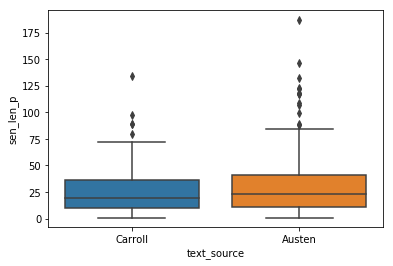

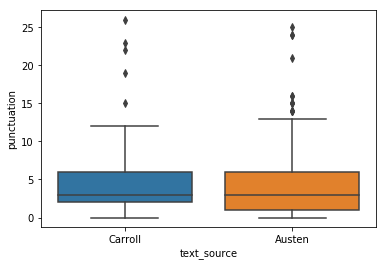

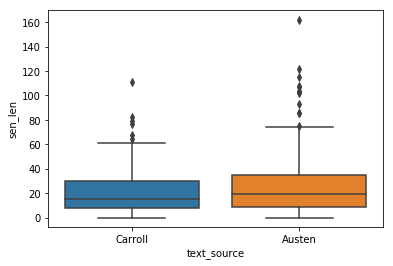

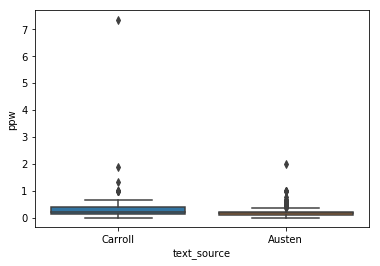

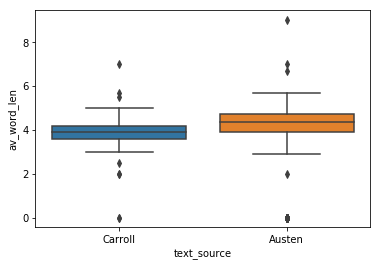

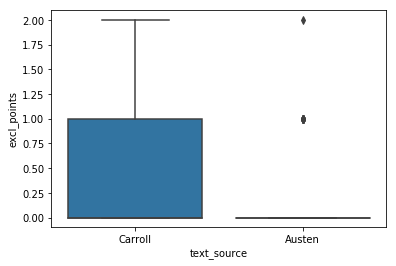

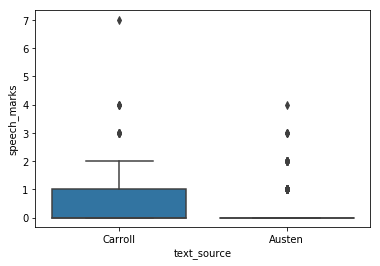

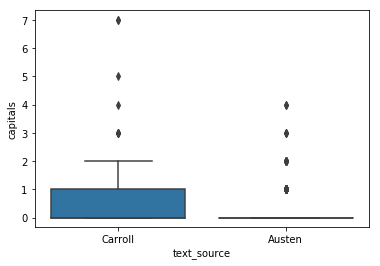

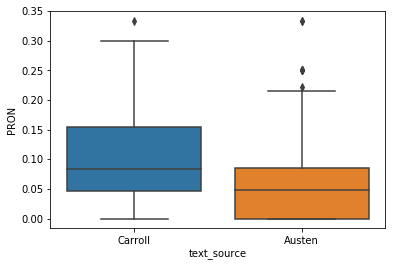

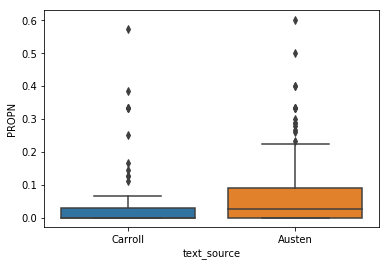

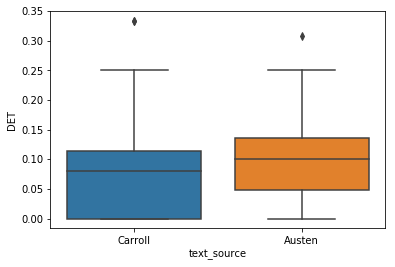

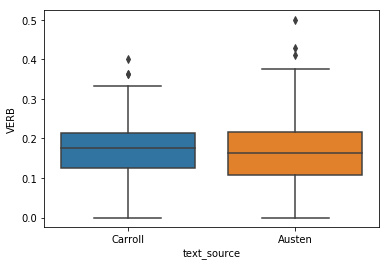

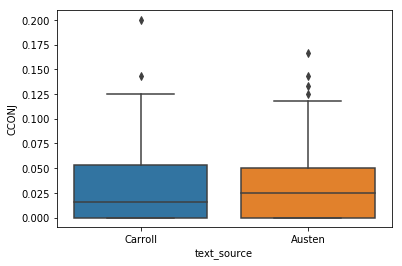

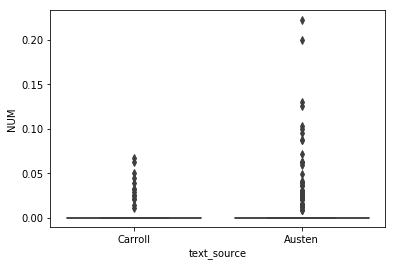

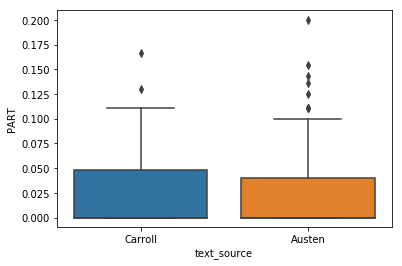

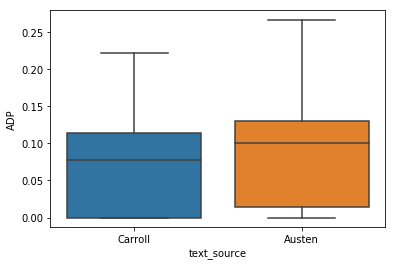

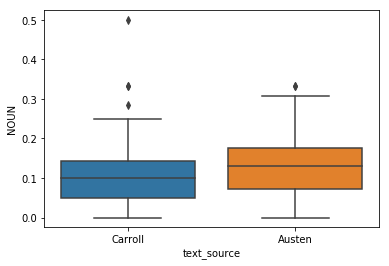

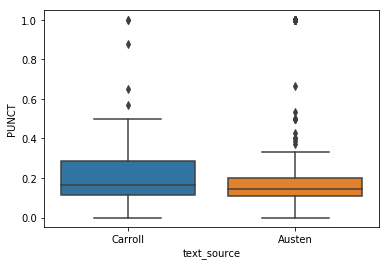

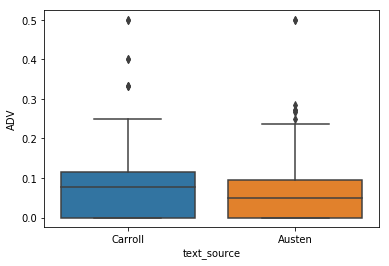

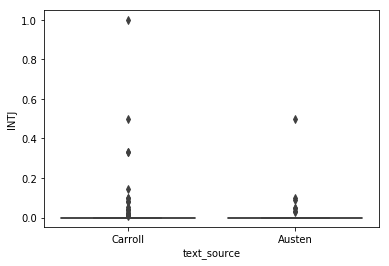

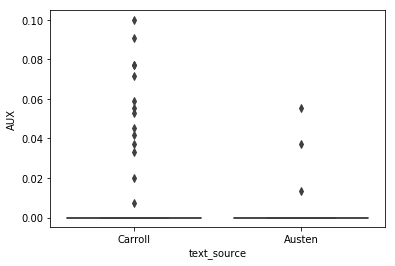

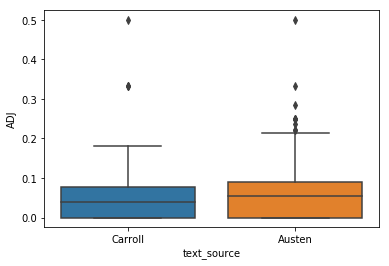

In [54]:
for col in new_features.columns[:22]:
    sns.boxplot(x=new_features['text_source'], y=new_features[col])
    plt.show()

In [55]:
## Drop features that are too similar

word_and_type_2 = word_and_type.copy()
word_and_type_2.drop(['sen_len_p', 'punctuation', 'ADP', 'CCONJ', 
                      'ADJ', 'ADV', 'VERB', 'PART', 'NOUN'], axis=1,
                    inplace=True)

In [56]:
## Test for performance improvement

y3 = word_and_type_2['text_source']
x3 = np.array(word_and_type_2.drop(['text_sentence', 'text_source'], 1))

x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.4, random_state=0)

In [57]:
lr3 = LogisticRegression(penalty='l2', random_state=99)
train_lr3 = lr3.fit(x3_train, y3_train)
print(x3_train.shape, y3_train.shape)
print('Training set score:', lr3.score(x3_train, y3_train))
print('\nTest set score:', lr3.score(x3_test, y3_test))

(266, 1625) (266,)
Training set score: 0.9774436090225563

Test set score: 0.8595505617977528


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [58]:
svm3 = SVC(random_state = 99)
train_svm3 = svm3.fit(x3_train, y3_train)
print('Training set score:', svm3.score(x3_train, y3_train))
print('\nTesting set score:', svm3.score(x3_test, y3_test))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training set score: 0.7142857142857143

Testing set score: 0.702247191011236


In [59]:
## Not helping!

### Only keep features which are very different between works

In [60]:
word_and_type_c = word_and_type.loc[word_and_type['text_source'] == 'Carroll', ]
word_and_type_a = word_and_type.loc[word_and_type['text_source'] == 'Austen', ]

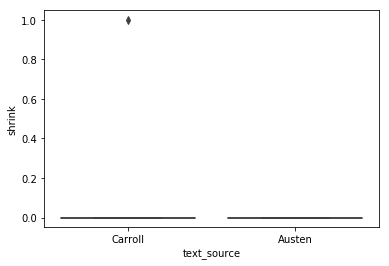

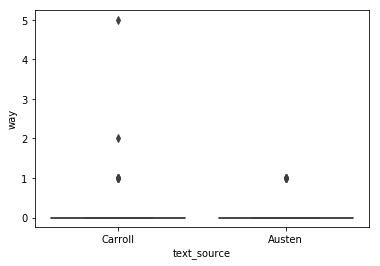

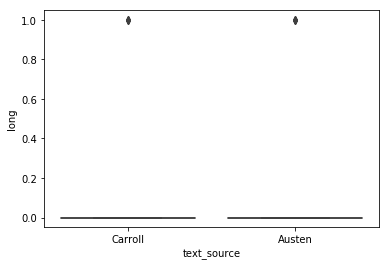

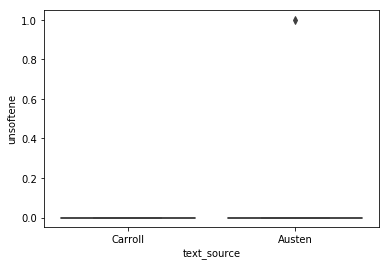

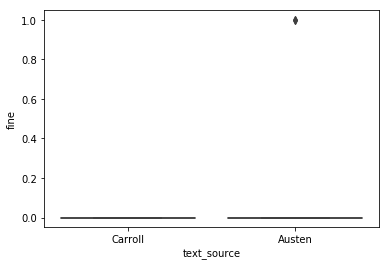

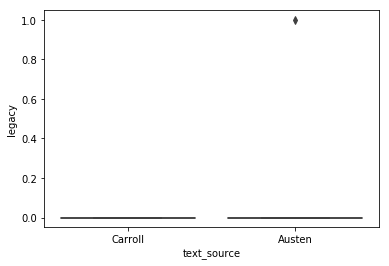

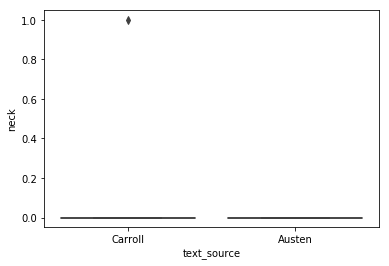

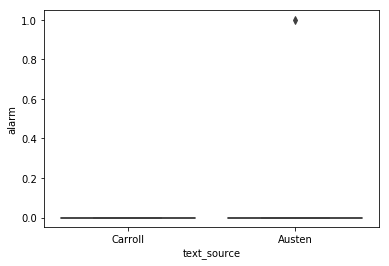

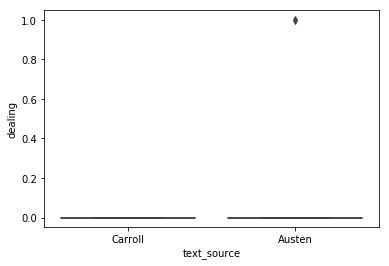

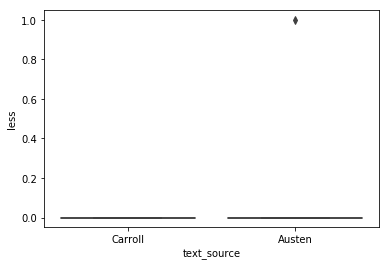

In [61]:
for col in word_and_type.columns[0:10]:
    sns.boxplot(x = word_and_type['text_source'], y= word_and_type[col])
    plt.show()

In [62]:
word_and_type_c.iloc[:, 0:10].describe()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less
count,129.000000,129.000000,129.000000,129.0,129.0,129.0,129.000000,129.0,129.0,129.0
mean,0.007752,0.124031,0.031008,0.0,0.0,0.0,0.007752,0.0,0.0,0.0
std,0.088045,0.530444,0.174014,0.0,0.0,0.0,0.088045,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
75%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
max,1.000000,5.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0


In [63]:
word_and_type_a.iloc[:, 0:10].describe()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less
count,315.0,315.000000,315.000000,315.000000,315.000000,315.000000,315.0,315.000000,315.000000,315.000000
mean,0.0,0.028571,0.012698,0.003175,0.006349,0.003175,0.0,0.003175,0.003175,0.003175
std,0.0,0.166864,0.112148,0.056344,0.079555,0.056344,0.0,0.056344,0.056344,0.056344
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [64]:
mean_diffs = abs(word_and_type_c.describe().loc['mean'] - word_and_type_a.describe().loc['mean'])

In [65]:
mean_diffs.sort_values(ascending=False)

sen_len           4.832853
sen_len_p         4.644371
speech_marks      0.465116
capitals          0.464157
excl_points       0.291694
Alice             0.263566
Sir               0.215873
Walter            0.215873
punctuation       0.188483
ppw               0.162577
av_word_len       0.154267
go                0.119085
think             0.105648
Elliot            0.104762
Mr                0.104762
Lady              0.101587
little            0.096493
way               0.095460
Anne              0.088889
Shepherd          0.088889
father            0.082540
man               0.082540
Russell           0.082540
fall              0.082097
like              0.078553
door              0.077519
Elizabeth         0.076190
wonder            0.074345
Kellynch          0.073016
eat               0.066593
                    ...   
certain           0.001403
kind              0.001403
cut               0.001403
pleasure          0.001403
work              0.001403
kill              0.001403
s

In [66]:
mean_diffs.describe()

count    1634.000000
mean        0.015817
std         0.167178
min         0.000369
25%         0.003175
50%         0.004577
75%         0.008121
max         4.832853
Name: mean, dtype: float64

In [67]:
mean_diffs_top = mean_diffs[mean_diffs > 0.004577]

In [68]:
std_diffs = abs(word_and_type_c.describe().loc['std'] - word_and_type_a.describe().loc['std'])

In [69]:
std_diffs.sort_values(ascending=False)

sen_len_p       5.172824
sen_len         4.727526
av_word_len     0.656676
capitals        0.622651
speech_marks    0.518821
ppw             0.497480
Walter          0.469858
Alice           0.459609
Sir             0.456100
punctuation     0.397303
way             0.363581
Mr              0.345779
Elliot          0.336443
Lady            0.322950
Elizabeth       0.320089
Shepherd        0.316787
man             0.308345
Anne            0.295998
father          0.286945
Russell         0.286945
Kellynch        0.272524
Rabbit          0.272487
door            0.268456
excl_points     0.264271
go              0.249702
bat             0.245601
tenant          0.241319
gentleman       0.235251
year            0.232485
bear            0.230914
                  ...   
certain         0.008490
able            0.008490
knowledge       0.008490
belong          0.008490
help            0.008490
new             0.008490
fond            0.008490
flower          0.008490
kind            0.008490


In [70]:
std_diffs.describe()

count    1634.000000
mean        0.085382
std         0.178390
min         0.001156
25%         0.056344
50%         0.056344
75%         0.088045
max         5.172824
Name: std, dtype: float64

In [71]:
std_diffs_top = std_diffs[std_diffs > 0.056344]

In [72]:
print(mean_diffs_top.shape)
print(std_diffs_top.shape)

(829,)
(750,)


In [73]:
top_features = set(list(mean_diffs_top.index)+list(std_diffs_top.index) + list(['text_source']))

In [74]:
len(top_features)

831

In [75]:
top_word_and_type = word_and_type.loc[:, top_features]

In [76]:
top_word_and_type.shape

(444, 831)

In [77]:
## Test for performance improvement

y4 = top_word_and_type['text_source']
x4 = np.array(top_word_and_type.drop(['text_source'], 1))

x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4, test_size=0.4, random_state=0)

In [78]:
lr4 = LogisticRegression(penalty='l2', random_state=99)
train_lr4 = lr4.fit(x4_train, y4_train)
print(x4_train.shape, y4_train.shape)
print('Training set score:', lr4.score(x4_train, y4_train))
print('\nTest set score:', lr4.score(x4_test, y4_test))

(266, 830) (266,)
Training set score: 0.9699248120300752

Test set score: 0.848314606741573


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [79]:
lr_params = {'C': [0.01, 0.1, 1, 10, 100], 'tol': [0.00001, 0.00005, 0.0001, 0.0005]}
gs_lr4 = GridSearchCV(lr4, lr_params, cv=5, n_jobs=3)

results4 = gs_lr4.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
results4.best_score_

0.8609022556390977

In [81]:
## Still worse than original!

## Compare with another book

In [82]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [83]:
thursday = gutenberg.raw('chesterton-thursday.txt')

In [86]:
thursday = re.sub(r'CHAPTER .*', '', thursday)

In [88]:
thursday = text_cleaner(thursday[:int(len(thursday)/10)])

In [89]:
thursday_doc = nlp(thursday)

In [90]:
thursday_sents = [[sent, 'Chesterton'] for sent in thursday_doc.sents]

In [91]:
thursday_pd = pd.DataFrame(thursday_sents)

In [93]:
thursdaywords = bag_of_words(thursday_doc)

In [94]:
## See how many of Alice / Persuasion words are in here

th_word_counts = bow_features(thursday_pd, common_words)

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450


In [95]:
th_word_counts.shape

(480, 1614)

In [107]:
len(common_words)

1612

In [96]:
## Type features

def type_features(df):

## Sentence length
    df['sen_len_p'] = np.nan
    for row in np.arange(0, len(df)):
        df.loc[row, 'sen_len_p'] = len(df.loc[row, 'text_sentence'])

## Punctuation in sentence

    df['punctuation'] = np.nan
    for row in np.arange(0, len(df)):
        punct = 0
        for token in df.loc[row, 'text_sentence']:
            if token.is_punct:
                punct += 1
        df.loc[row, 'punctuation'] = punct
    
## Sentence length without punctuation

    df['sen_len'] = df['sen_len_p'] - df['punctuation']

## Punctuation per word

    df['ppw'] = df['punctuation'] / df['sen_len']

## Average word length in a sentence

    df['av_word_len'] = np.nan

    for row in np.arange(0, len(df)):
        total_l = 0
        for token in df.loc[row, 'text_sentence']:
            if (not token.is_punct):
                total_l += len(token)
            av_l = total_l / df.loc[row, 'sen_len']
        df.loc[row, 'av_word_len'] = av_l
    
    ## Exclamation points

    df['excl_points'] = np.nan

    for row in np.arange(0, len(df)):
        total_l = 0
        for token in df.loc[row, 'text_sentence']:
            if (str(token) == str(nlp('!')[0])):
                total_l += 1
        df.loc[row, 'excl_points'] = total_l
    
## Speech marks (' or ")
## Put these together because not fair to use as separator because
## just chance of formatting.
## Will include apostrophes as well I guess

    df['speech_marks'] = np.nan

    for row in np.arange(0, len(df)):
        speech = 0
        for token in df.loc[row, 'text_sentence']:
            if(str(token) == str('"')):
                speech += 1
            elif(str(token) == str("'")):
                speech += 1
        df.loc[row, 'speech_marks'] = speech
    
    
## Words in capitals

    df['capitals'] = np.nan

    for row in np.arange(0, len(df)):
        caps = 0
        for token in df.loc[row, 'text_sentence']:
            if(re.match(r'\b[A-Z]+\b', str(token))):
                caps += 1
        df.loc[row, 'capitals'] = caps
        
    return df

In [97]:
thursday_sent_type = type_features(th_word_counts)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


In [108]:
thursday_sent_type.shape

(480, 1622)

In [141]:
thursday_sent_type.iloc[:10, 1600:]

,summer,tempt,order,Sir,Basil,nation,privilege,longer,urge,spurn,...,text_sentence,text_source,sen_len_p,punctuation,sen_len,ppw,av_word_len,excl_points,speech_marks,capitals
0,0,0,0,0,0,0,0,0,0,0,...,"(To, Edmund, Clerihew, Bentley, A, cloud, was,...",Chesterton,33.0,4.0,29.0,0.137931,4.000000,0.0,0.0,1.0
1,0,0,1,0,0,0,0,0,0,0,...,"(Science, announced, nonentity, and, art, admi...",Chesterton,45.0,5.0,40.0,0.125000,4.300000,0.0,0.0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,"(Like, the, white, lock, of, Whistler, ,, that...",Chesterton,25.0,3.0,22.0,0.136364,4.272727,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,"(Life, was, a, fly, that, faded, ,, and, death...",Chesterton,27.0,3.0,24.0,0.125000,3.625000,0.0,0.0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,"(They, twisted, even, decent, sin, to, shapes,...",Chesterton,24.0,3.0,21.0,0.142857,4.047619,0.0,0.0,0.0
5,0,0,0,0,0,0,0,0,0,0,...,"(Weak, if, we, were, and, foolish, ,, not, thu...",Chesterton,29.0,3.0,26.0,0.115385,4.000000,0.0,0.0,0.0
6,0,0,0,0,0,0,0,0,0,0,...,"(we, were, our, forts, of, sand, were, even, a...",Chesterton,13.0,1.0,12.0,0.083333,3.250000,0.0,0.0,0.0
7,0,0,0,0,0,0,0,0,0,0,...,"(High, as, they, went)",Chesterton,4.0,0.0,4.0,0.000000,3.500000,0.0,0.0,0.0
8,0,0,0,0,0,0,0,0,0,0,...,"(we, piled, them, up, to, break, that, bitter,...",Chesterton,10.0,1.0,9.0,0.111111,3.666667,0.0,0.0,0.0
9,0,0,0,0,0,0,0,0,0,0,...,"(Fools, as, we, were, in, motley, ,, all, jang...",Chesterton,25.0,3.0,22.0,0.136364,4.136364,0.0,0.0,0.0


In [98]:
thursday_type = bow_features2(th_word_counts)

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450


In [145]:
thursday_type.columns

Index(['PROPN', 'DET', 'VERB', 'CCONJ', 'NUM', 'ADJ', 'PART', 'ADP', 'NOUN',
       'PRON', 'ADV', 'INTJ', 'AUX', 'PUNCT', 'X', 'text_sentence'],
      dtype='object')

In [146]:
thursday_word_and_type = pd.concat([thursday_sent_type, thursday_type.drop(['text_sentence'], axis=1)], axis=1)

In [147]:
thursday_word_and_type.head()

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,ADJ,PART,ADP,NOUN,PRON,ADV,INTJ,AUX,PUNCT,X
0,0,0,0,0,0,0,0,0,0,0,...,0.030303,0,0.121212,0.242424,0.030303,0.0606061,0,0,0.121212,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0888889,0,0.0222222,0.222222,0.0666667,0,0,0,0.111111,0
2,0,0,0,0,0,0,0,0,0,0,...,0.16,0,0.12,0.2,0,0.08,0,0,0.12,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0740741,0,0,0.222222,0.0740741,0.111111,0,0,0.111111,0
4,0,0,0,0,0,0,0,0,0,0,...,0.125,0.0416667,0.0833333,0.166667,0.0833333,0.125,0,0,0.125,0


In [148]:
thursday_word_and_type.replace([np.inf, -np.inf], np.nan, inplace=True)
thursday_word_and_type = thursday_word_and_type.fillna(0)

In [149]:
thursday_word_and_type[thursday_word_and_type.isnull().any(axis=1)]

,shrink,way,long,unsoftene,fine,legacy,neck,alarm,dealing,less,...,ADJ,PART,ADP,NOUN,PRON,ADV,INTJ,AUX,PUNCT,X


In [154]:
new_df_reshape = thursday_word_and_type.loc[:, thursday_word_and_type.columns.isin(top_word_and_type.columns)]

In [161]:
new_df_reshape.shape

(480, 831)

In [162]:
top_word_and_type.shape

(444, 831)

In [164]:
all_authors = pd.concat([top_word_and_type, new_df_reshape], sort=False)

In [165]:
all_authors.shape

(924, 831)

In [166]:
all_authors.head()

,shrink,way,fortune,strong,White,pardon,course,admiral,long,corner,...,Basil,add,privilege,credit,cool,tear,plan,deep,shut,dressed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Test Alice vs other

In [169]:
alice_thursday = all_authors.loc[all_authors['text_source'].isin(['Carroll', 'Chesterton']), ]

In [170]:
alice_thursday_x = alice_thursday.drop(['text_source'], axis=1)
alice_thursday_y = alice_thursday['text_source']

In [171]:
## Test it

print('\nTest set score:', lr4.score(alice_thursday_x, alice_thursday_y))


Test set score: 0.17077175697865354


#### Test Persuasion vs other

In [172]:
per_thur = all_authors.loc[all_authors['text_source'].isin(['Austen', 'Chesterton']),]
per_thur_x = per_thur.drop(['text_source'], axis=1)
per_thur_y = per_thur['text_source']

In [173]:
## Test it

print('\nTest set score:', lr4.score(per_thur_x, per_thur_y))


Test set score: 0.3836477987421384


In [174]:
## This implies that Alice and Thursday are more similar because they are harder to distinguish.